In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

sys.path.append(r'/user/gr1/delphi/dghezzi/UNet')

from UNet import UnetDoubleEncoder


def infer_double_encoder(model, img_path_full, device='cpu', patch_size=416):
    """
    Carica immagine full, estrae patch centrale, fa inferenza col modello doppio encoder.
    
    Parameters:
    - model: il modello UnetDoubleEncoder già caricato e in eval mode
    - img_path_full: path file .npy immagine intera (es. 800x800)
    - device: 'cpu' o 'cuda'
    - patch_size: dimensione del lato del crop centrale (default 416)
    
    Returns:
    - output_np: numpy array con la heatmap predetta (shape HxW)
    """
    # Carica immagine intera
    img_full = np.load(img_path_full).astype(np.float32)  # (H, W)
    
    # Funzione per crop centrale
    def crop_center(img, cropx, cropy):
        y, x = img.shape
        startx = x//2 - (cropx//2)
        starty = y//2 - (cropy//2)
        return img[starty:starty+cropy, startx:startx+cropx]
    
    # Estrai patch centrale
    img_patch = crop_center(img_full, patch_size, patch_size)
    
    # Prepara tensori: aggiungi canale e batch dimension
    img_full_tensor = torch.from_numpy(img_full).unsqueeze(0).unsqueeze(0).to(device)  # (1,1,H,W)
    img_patch_tensor = torch.from_numpy(img_patch).unsqueeze(0).unsqueeze(0).to(device)  # (1,1,patch_size,patch_size)
    
    # Inferenza
    model.to(device)
    model.eval()
    with torch.no_grad():
        output = model(img_full_tensor, img_patch_tensor)  # (1,1,H,W) o shape output
        output = torch.sigmoid(output)
    
    output_np = output.squeeze(0).squeeze(0).cpu().numpy()
    return output_np

Device usato: cuda


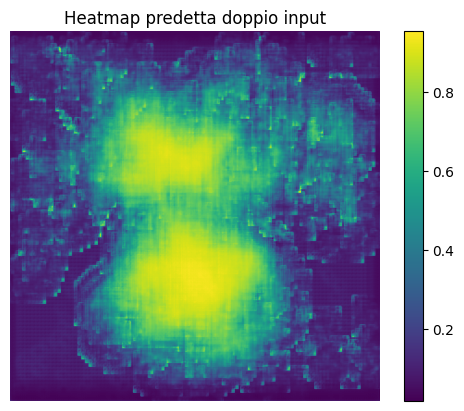

Heatmap salvata in: /user/gr1/delphi/dghezzi/UNet/Models/event_92_heatmap_pred.png
Output heatmap shape: (800, 800)
Min: 0.01712281
Max: 0.9530445
Mean: 0.3549916


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device usato: {device}")

# Istanzia e carica modello (adatta path e classe)
model = UnetDoubleEncoder(in_channels1=1, in_channels2=1, base_channels=64, out_channels=1)
model_path = "best_double_encoder_unet.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Path immagine .npy
img_path = '/user/gr1/delphi/dghezzi/UNet/Models/event_92.npy'

# Inferenza
heatmap_pred = infer_double_encoder(model, img_path, device=device, patch_size=416)

# Visualizza heatmap
plt.imshow(heatmap_pred, cmap='viridis')
plt.title("Heatmap predetta doppio input")
plt.colorbar()
plt.axis('off')
plt.show()

# Salva immagine heatmap predetta
save_path = os.path.splitext(img_path)[0] + "_heatmap_pred.png"
plt.imsave(save_path, heatmap_pred, cmap='viridis')
print(f"Heatmap salvata in: {save_path}")

# Statistiche output
print("Output heatmap shape:", heatmap_pred.shape)
print("Min:", heatmap_pred.min())
print("Max:", heatmap_pred.max())
print("Mean:", heatmap_pred.mean())